📊 ANÁLISIS DE DESBALANCE DE CLASES

📁 Clases encontradas: 6
🖼️  Total de imágenes: 7255

Distribución por clase:
------------------------------------------------------------
AVE_GRANDE                | 3092 imágenes |  42.6% █████████████████████
AVE_PEQUEÑA               | 1277 imágenes |  17.6% ████████
OUTLIERS                  | 1145 imágenes |  15.8% ███████
MAMIFERO_MEDIANO          | 1008 imágenes |  13.9% ██████
MAMIFERO_GRANDE           |  500 imágenes |   6.9% ███
MAMIFERO_PEQUEÑO          |  233 imágenes |   3.2% █

📈 MÉTRICAS DE DESBALANCE
Clase con MÁS imágenes:    3092 imágenes
Clase con MENOS imágenes:  233 imágenes
Promedio por clase:         1209.2 imágenes
Ratio de desbalance:        13.27x


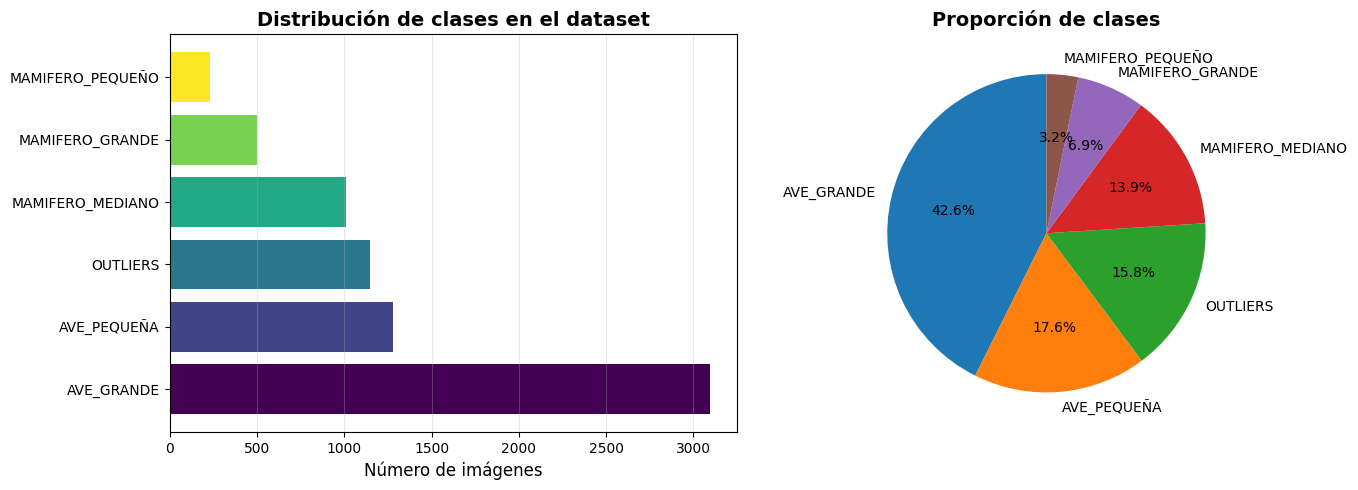

In [1]:
import os
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Analizar desbalance de clases
def analyze_dataset_balance(root_path):
    """
    Analiza el desbalance de clases en el dataset
    """
    class_counts = {}
    classes = sorted(os.listdir(root_path))
    
    print("=" * 60)
    print("📊 ANÁLISIS DE DESBALANCE DE CLASES")
    print("=" * 60)
    
    for cls in classes:
        folder = os.path.join(root_path, cls)
        if os.path.isdir(folder):
            count = len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
            class_counts[cls] = count
    
    # Mostrar estadísticas
    total_images = sum(class_counts.values())
    sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\n📁 Clases encontradas: {len(class_counts)}")
    print(f"🖼️  Total de imágenes: {total_images}\n")
    
    print("Distribución por clase:")
    print("-" * 60)
    for cls, count in sorted_classes:
        percentage = (count / total_images) * 100
        bar = "█" * int(percentage / 2)
        print(f"{cls:25} | {count:4} imágenes | {percentage:5.1f}% {bar}")
    
    # Calcular métricas de desbalance
    min_class = min(class_counts.values())
    max_class = max(class_counts.values())
    mean_class = total_images / len(class_counts)
    
    print("\n" + "=" * 60)
    print("📈 MÉTRICAS DE DESBALANCE")
    print("=" * 60)
    print(f"Clase con MÁS imágenes:    {max_class} imágenes")
    print(f"Clase con MENOS imágenes:  {min_class} imágenes")
    print(f"Promedio por clase:         {mean_class:.1f} imágenes")
    print(f"Ratio de desbalance:        {max_class / min_class:.2f}x")
    
    # Visualizar
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfico de barras
    names = [cls for cls, _ in sorted_classes]
    counts = [count for _, count in sorted_classes]
    colors = plt.cm.viridis(np.linspace(0, 1, len(names)))
    
    ax1.barh(names, counts, color=colors)
    ax1.set_xlabel("Número de imágenes", fontsize=12)
    ax1.set_title("Distribución de clases en el dataset", fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Gráfico de pastel
    ax2.pie(counts, labels=names, autopct='%1.1f%%', startangle=90)
    ax2.set_title("Proporción de clases", fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return class_counts


# Ejecutar análisis
dataset_path = "/home/aldrinchp/Documents/DATASET_WILDLIFE"
class_distribution = analyze_dataset_balance(dataset_path)

In [2]:
import torch
import timm
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np

# Ruta de los pesos DeepFaune
weights_path = "/media/aldrinchp/KAli-HDD/Subjects/8vo_AA_MA/Image Proccesing/FINAL/Fine_tunning_vision/deepfaune-vit_large_patch14_dinov2.lvd142m.v4.pt"

# Crear el modelo ViT idéntico
vit = timm.create_model(
    "vit_large_patch14_dinov2.lvd142m",
    pretrained=False,
    num_classes=38,  # El checkpoint tiene 38 clases, no 39
    dynamic_img_size=True
)

# Configurar dispositivo (GPU si está disponible, sino CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

checkpoint = torch.load(weights_path, map_location=device, weights_only=False)

# Remover el prefijo "base_model." de las claves del checkpoint
state_dict = checkpoint["state_dict"]
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith("base_model."):
        new_key = key.replace("base_model.", "")
        new_state_dict[new_key] = value
    else:
        new_state_dict[key] = value

vit.load_state_dict(new_state_dict)
vit = vit.to(device)  # Mover modelo a GPU
vit.eval()  # modo inferencia

# Congelar parámetros del ViT
for p in vit.parameters():
    p.requires_grad = False

# Preprocesamiento oficial DeepFaune
preprocess = transforms.Compose([
    transforms.Resize((182, 182)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


Usando dispositivo: cuda


In [3]:
from torch.utils.data import WeightedRandomSampler

# ════════════════════════════════════════════════════════════════════════════
# TÉCNICA 1: WeightedRandomSampler (APLICADA EN ENTRENAMIENDO)
# ════════════════════════════════════════════════════════════════════════════
def get_balanced_sampler(y, batch_size=32):
    """
    Crea un sampler que balancea automáticamente el dataset
    Cada batch tendrá una distribución equilibrada de clases
    
    ✅ ESTA TÉCNICA SE USA EN train_mlp_balanced()
    """
    class_counts = np.bincount(y)
    weights = 1.0 / class_counts[y]  # Peso inverso a la frecuencia
    sampler = WeightedRandomSampler(
        weights=weights,
        num_samples=len(y),
        replacement=True
    )
    return sampler


# ════════════════════════════════════════════════════════════════════════════
# TÉCNICA 2: Class Weights en Loss (APLICADA EN ENTRENAMIENTO)
# ════════════════════════════════════════════════════════════════════════════
def get_class_weights(y, num_classes=None):
    """
    Calcula pesos inversamente proporcionales a la frecuencia
    Penaliza más los errores en clases minoritarias
    
    ✅ ESTA TÉCNICA SE USA EN train_mlp_balanced()
    """
    if num_classes is None:
        num_classes = len(np.unique(y))
    
    class_counts = np.bincount(y, minlength=num_classes)
    total = len(y)
    
    # Peso inverso: clases raras tienen más peso
    weights = total / (num_classes * class_counts.astype(float))
    
    return torch.tensor(weights, dtype=torch.float32).to(device)


# ════════════════════════════════════════════════════════════════════════════
# FUNCIÓN PRINCIPAL: train_mlp_balanced()
# APLICA LAS TÉCNICAS 1 Y 2 DURANTE EL ENTRENAMIENTO
# CON VALIDACIÓN Y EARLY STOPPING
# ════════════════════════════════════════════════════════════════════════════
def train_mlp_balanced(X, y, X_val, y_val, classes, epochs=40, lr=1e-3, batch_size=32, 
                       use_weights=True, patience=10, save_path="best_model.pth"):
    """
    Entrena el MLP aplicando TÉCNICA 1 y TÉCNICA 2 con validación durante entrenamiento
    
    ✅ TÉCNICA 1: WeightedRandomSampler → batches balanceados
    ✅ TÉCNICA 2: Class Weights → loss ponderada
    ✅ MEJORÍA 1: Validación durante entrenamiento
    ✅ MEJORÍA 2: Early stopping basado en val F1-Score
    ✅ MEJORÍA 3: Guardar mejor modelo
    
    Args:
        X, y: Datos de entrenamiento
        X_val, y_val: Datos de validación
        classes: Lista de nombres de clases
        epochs: Máximo de epochs
        patience: Epochs sin mejora antes de parar (default=10)
        save_path: Donde guardar el mejor modelo
    """
    from sklearn.metrics import f1_score
    
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)

    dataset = torch.utils.data.TensorDataset(X, y)
    
    # ════════════════════════════════════════════════════════════════════════
    # AQUÍ ENTRA TÉCNICA 1: WeightedRandomSampler
    # ════════════════════════════════════════════════════════════════════════
    sampler = get_balanced_sampler(y.numpy(), batch_size=batch_size)
    loader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=batch_size, 
        sampler=sampler  # ← TÉCNICA 1 ACTIVA AQUÍ
    )
    
    model = MLPClassifier(num_classes=len(classes)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # ════════════════════════════════════════════════════════════════════════
    # AQUÍ ENTRA TÉCNICA 2: Class Weights
    # ════════════════════════════════════════════════════════════════════════
    if use_weights:
        class_weights = get_class_weights(y.numpy(), num_classes=len(classes))
        criterion = nn.CrossEntropyLoss(weight=class_weights)  # ← TÉCNICA 2 ACTIVA AQUÍ
    else:
        criterion = nn.CrossEntropyLoss()

    # ════════════════════════════════════════════════════════════════════════
    # VARIABLES PARA EARLY STOPPING Y MEJOR MODELO
    # ════════════════════════════════════════════════════════════════════════
    best_f1 = 0
    patience_counter = 0
    history = {
        'train_loss': [],
        'val_f1': [],
        'val_accuracy': []
    }
    
    print("\n" + "=" * 70)
    print("🔀 ENTRENAMIENTO CON VALIDACIÓN Y EARLY STOPPING")
    print("=" * 70)
    print(f"Patience: {patience} epochs sin mejora")
    print("=" * 70 + "\n")

    for epoch in range(epochs):
        # ════════════════════════════════════════════════════════════════════
        # ENTRENAMIENTO
        # ════════════════════════════════════════════════════════════════════
        model.train()
        total_loss = 0
        batch_count = 0

        for xb, yb in loader:  # ← loader usa TÉCNICA 1
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)  # ← criterion usa TÉCNICA 2
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batch_count += 1

        avg_loss = total_loss / batch_count
        history['train_loss'].append(avg_loss)

        # ════════════════════════════════════════════════════════════════════
        # VALIDACIÓN DURANTE ENTRENAMIENTO (MEJORÍA 1)
        # ════════════════════════════════════════════════════════════════════
        model.eval()
        with torch.no_grad():
            X_val_device = X_val.to(device)
            val_logits = model(X_val_device)
            val_predictions = torch.argmax(val_logits, dim=1).cpu().numpy()
        
        y_val_np = y_val.numpy()
        val_f1 = f1_score(y_val_np, val_predictions, average='weighted', zero_division=0)
        val_accuracy = (val_predictions == y_val_np).mean()
        
        history['val_f1'].append(val_f1)
        history['val_accuracy'].append(val_accuracy)

        # ════════════════════════════════════════════════════════════════════
        # EARLY STOPPING (MEJORÍA 2)
        # ════════════════════════════════════════════════════════════════════
        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            
            # ════════════════════════════════════════════════════════════════
            # GUARDAR MEJOR MODELO (MEJORÍA 3)
            # ════════════════════════════════════════════════════════════════
            torch.save({
                'model_state_dict': model.state_dict(),
                'epoch': epoch,
                'val_f1': val_f1,
                'val_accuracy': val_accuracy
            }, save_path)
            
            marker = "⭐ NUEVO MEJOR"
        else:
            patience_counter += 1
            marker = ""

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Loss: {avg_loss:.4f} | "
              f"Val F1: {val_f1:.4f} | "
              f"Val Acc: {val_accuracy:.4f} | "
              f"Patience: {patience_counter}/{patience} {marker}")

        # Early stopping
        if patience_counter >= patience:
            print(f"\n⏹️  EARLY STOPPING en epoch {epoch+1}")
            print(f"   Sin mejora en {patience} epochs")
            print(f"   Mejor F1-Score: {best_f1:.4f}")
            break

    print("\n" + "=" * 70)
    print("✅ Entrenamiento completado")
    print(f"   Mejor Val F1-Score: {best_f1:.4f}")
    print(f"   Total epochs: {epoch+1}/{epochs}")
    print("=" * 70)
    
    return model, history, best_f1


In [4]:
# OPCIÓN 5: Data Augmentation para clases minoritarias (IMPORTANTE PARA DESBALANCE SEVERO)
def augment_dataset_minority_classes(X, y, classes, target_ratio=0.8):
    """
    Aumenta las imágenes de clases minoritarias mediante transformaciones
    
    Args:
        X: Embeddings del dataset
        y: Labels del dataset
        classes: Nombres de las clases
        target_ratio: Ratio mínimo deseado para la clase más pequeña (0.8 = 80% de la mayor)
    """
    class_counts = np.bincount(y)
    max_count = np.max(class_counts)
    target_count = int(max_count * target_ratio)
    
    X_augmented = X.copy()
    y_augmented = y.copy()
    
    print("\n📈 AUMENTANDO CLASES MINORITARIAS")
    print("=" * 60)
    
    for class_idx, count in enumerate(class_counts):
        if count < target_count:
            # Seleccionar índices de esta clase
            class_indices = np.where(y == class_idx)[0]
            shortage = target_count - count
            
            # Duplicar aleatoriamente samples de esta clase
            augmented_indices = np.random.choice(class_indices, size=shortage, replace=True)
            
            # Agregar pequeño ruido a los embeddings duplicados (pequeña variación)
            augmented_samples = X[augmented_indices] + np.random.normal(0, 0.01, X[augmented_indices].shape)
            
            X_augmented = np.vstack([X_augmented, augmented_samples])
            y_augmented = np.concatenate([y_augmented, np.full(shortage, class_idx)])
            
            print(f"{classes[class_idx]:25} | Original: {count:4} → Aumentado a: {count + shortage:4}")
    
    print("=" * 60)
    print(f"Total original: {len(y)} imágenes")
    print(f"Total después de augmentation: {len(y_augmented)} imágenes")
    
    return X_augmented, y_augmented


In [5]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=1024, hidden=512, num_classes=6):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x):
        return self.net(x)
    

In [ ]:
import os

def extract_embedding(image_path):
    img = Image.open(image_path).convert("RGB")
    x = preprocess(img).unsqueeze(0).to(device)  # Mover input a GPU

    with torch.no_grad():
        features = vit.forward_features(x)  # salida del ViT
        emb = features[:, 0, :]            # token CLS
    return emb.squeeze(0).cpu()            # Devolver a CPU para numpy


def load_dataset(root):
    X = []
    y = []
    classes = sorted(os.listdir(root))  # nombres de clases
    
    for label_idx, cls in enumerate(classes):
        folder = os.path.join(root, cls)
        for fname in os.listdir(folder):
            path = os.path.join(folder, fname)
            emb = extract_embedding(path)
            X.append(emb.numpy())
            y.append(label_idx)

    return np.array(X), np.array(y), classes



def predict_image(path, mlp, classes):
    emb = extract_embedding(path)
    emb_tensor = torch.tensor(emb).unsqueeze(0).to(device)  # Mover a GPU
    logits = mlp(emb_tensor)
    probs = torch.softmax(logits, dim=1)[0].cpu().numpy()  # Devolver a CPU
    idx = np.argmax(probs)
    return classes[idx], float(probs[idx])




In [7]:
# ════════════════════════════════════════════════════════════════════════════
# CARGAR DATASET ORIGINAL
# ════════════════════════════════════════════════════════════════════════════

print("=" * 70)
print("📥 CARGANDO DATASET Y EXTRAYENDO EMBEDDINGS")
print("=" * 70)

X, y, classes = load_dataset("/home/aldrinchp/Documents/DATASET_WILDLIFE")

print(f"\n✅ Dataset cargado exitosamente:")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")
print(f"   Clases: {classes}")
print("=" * 70)


📥 CARGANDO DATASET Y EXTRAYENDO EMBEDDINGS



✅ Dataset cargado exitosamente:
   X shape: (7255, 1024)
   y shape: (7255,)
   Clases: ['AVE_GRANDE', 'AVE_PEQUEÑA', 'MAMIFERO_GRANDE', 'MAMIFERO_MEDIANO', 'MAMIFERO_PEQUEÑO', 'OUTLIERS']


In [8]:
from sklearn.model_selection import train_test_split

# ════════════════════════════════════════════════════════════════════════════
# PASO 1: DIVIDIR DATASET ORIGINAL EN TRAIN / VALIDATION / TEST
# ════════════════════════════════════════════════════════════════════════════

X_original = X
y_original = y

print("=" * 70)
print("🔀 PASO 1: DIVIDIENDO DATASET ORIGINAL EN TRAIN / VAL / TEST")
print("=" * 70)

# Paso 1: Dividir en train+val (80%) y test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_original, y_original, 
    test_size=0.2, 
    random_state=42,
    stratify=y_original
)

# Paso 2: Dividir train+val en train (80%) y val (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.2,
    random_state=42,
    stratify=y_temp
)

print(f"\n📊 DISTRIBUCIÓN FINAL:")
print(f"   Train:      {len(X_train)} imágenes ({len(X_train)/len(X_original)*100:.1f}%)")
print(f"   Validation: {len(X_val)} imágenes ({len(X_val)/len(X_original)*100:.1f}%)")
print(f"   Test:       {len(X_test)} imágenes ({len(X_test)/len(X_original)*100:.1f}%)")
print(f"   Total:      {len(X_original)} imágenes")
print("=" * 70)

# ════════════════════════════════════════════════════════════════════════════
# PASO 2: AUMENTAR SOLO LOS DATOS DE TRAIN
# ════════════════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("🔀 PASO 2: APLICANDO TÉCNICAS DE BALANCEO AL CONJUNTO DE TRAIN")
print("=" * 70)

# Data Augmentation SOLO en train
X_train_balanced, y_train_balanced = augment_dataset_minority_classes(
    X_train, y_train, classes, target_ratio=0.8
)

print(f"\n✅ Datos de train aumentados:")
print(f"   Antes: {len(X_train)} imágenes")
print(f"   Después: {len(X_train_balanced)} imágenes")

# ════════════════════════════════════════════════════════════════════════════
# PASO 3: ENTRENAR CON LOS DATOS BALANCEADOS (CON VALIDACIÓN Y EARLY STOPPING)
# ════════════════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("🔀 PASO 3: ENTRENANDO MLP CON VALIDACIÓN EN TIEMPO REAL")
print("=" * 70 + "\n")

mlp, training_history, best_val_f1 = train_mlp_balanced(
    X_train_balanced, 
    y_train_balanced,
    X_val,  # ← Ahora pasamos validation set
    y_val,
    classes,
    epochs=40,
    use_weights=True,
    patience=10,  # Early stopping después de 10 epochs sin mejora
    save_path="best_mlp_model.pth"  # Guardar mejor modelo
)


🔀 PASO 1: DIVIDIENDO DATASET ORIGINAL EN TRAIN / VAL / TEST

📊 DISTRIBUCIÓN FINAL:
   Train:      4643 imágenes (64.0%)
   Validation: 1161 imágenes (16.0%)
   Test:       1451 imágenes (20.0%)
   Total:      7255 imágenes

🔀 PASO 2: APLICANDO TÉCNICAS DE BALANCEO AL CONJUNTO DE TRAIN

📈 AUMENTANDO CLASES MINORITARIAS
AVE_PEQUEÑA               | Original:  817 → Aumentado a: 1583
MAMIFERO_GRANDE           | Original:  320 → Aumentado a: 1583
MAMIFERO_MEDIANO          | Original:  645 → Aumentado a: 1583
MAMIFERO_PEQUEÑO          | Original:  149 → Aumentado a: 1583
OUTLIERS                  | Original:  733 → Aumentado a: 1583
Total original: 4643 imágenes
Total después de augmentation: 9894 imágenes

✅ Datos de train aumentados:
   Antes: 4643 imágenes
   Después: 9894 imágenes

🔀 PASO 3: ENTRENANDO MLP CON VALIDACIÓN EN TIEMPO REAL


🔀 ENTRENAMIENTO CON VALIDACIÓN Y EARLY STOPPING
Patience: 10 epochs sin mejora

Epoch 1/40 | Loss: 0.2938 | Val F1: 0.8089 | Val Acc: 0.8036 | Patience:

## 📊 Evaluación del Modelo MLP

Ahora evaluaremos el modelo entrenado con métricas completas (Accuracy, Precision, Recall, F1-Score) y visualizaciones.


📊 GRÁFICAS DEL HISTÓRICO DE ENTRENAMIENTO



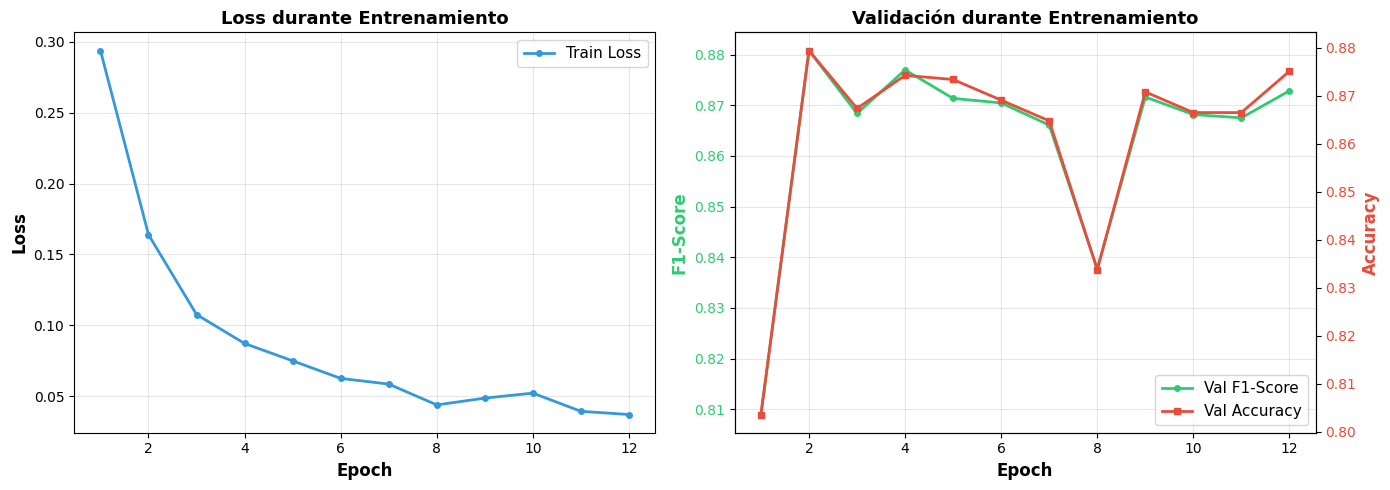

✅ Gráficas generadas

📈 Resumen:
   Total epochs entrenados: 12
   Mejor Val F1-Score: 0.8808
   Final Train Loss: 0.0371
   Final Val F1-Score: 0.8729
   Final Val Accuracy: 0.8751


In [9]:
# ════════════════════════════════════════════════════════════════════════════
# VISUALIZAR HISTÓRICO DE ENTRENAMIENTO
# ════════════════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("📊 GRÁFICAS DEL HISTÓRICO DE ENTRENAMIENTO")
print("=" * 70 + "\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica 1: Loss durante entrenamiento
epochs_range = range(1, len(training_history['train_loss']) + 1)
axes[0].plot(epochs_range, training_history['train_loss'], 'o-', linewidth=2, markersize=4, label='Train Loss', color='#3498db')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Loss durante Entrenamiento', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=11)

# Gráfica 2: Validation F1 y Accuracy
ax2_1 = axes[1]
ax2_2 = ax2_1.twinx()

line1 = ax2_1.plot(epochs_range, training_history['val_f1'], 'o-', linewidth=2, markersize=4, 
                    label='Val F1-Score', color='#2ecc71')
line2 = ax2_2.plot(epochs_range, training_history['val_accuracy'], 's-', linewidth=2, markersize=4, 
                    label='Val Accuracy', color='#e74c3c')

ax2_1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2_1.set_ylabel('F1-Score', fontsize=12, fontweight='bold', color='#2ecc71')
ax2_2.set_ylabel('Accuracy', fontsize=12, fontweight='bold', color='#e74c3c')
ax2_1.set_title('Validación durante Entrenamiento', fontsize=13, fontweight='bold')
ax2_1.tick_params(axis='y', labelcolor='#2ecc71')
ax2_2.tick_params(axis='y', labelcolor='#e74c3c')
ax2_1.grid(True, alpha=0.3)

# Leyenda combinada
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2_1.legend(lines, labels, loc='lower right', fontsize=11)

plt.tight_layout()
plt.show()

print("✅ Gráficas generadas")
print(f"\n📈 Resumen:")
print(f"   Total epochs entrenados: {len(training_history['train_loss'])}")
print(f"   Mejor Val F1-Score: {best_val_f1:.4f}")
print(f"   Final Train Loss: {training_history['train_loss'][-1]:.4f}")
print(f"   Final Val F1-Score: {training_history['val_f1'][-1]:.4f}")
print(f"   Final Val Accuracy: {training_history['val_accuracy'][-1]:.4f}")


In [10]:
# ════════════════════════════════════════════════════════════════════════════
# CARGAR EL MEJOR MODELO (MEJORÍA 3)
# ════════════════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("📥 CARGANDO MEJOR MODELO PARA EVALUACIÓN")
print("=" * 70)

# Cargar el checkpoint del mejor modelo
best_checkpoint = torch.load("best_mlp_model.pth", map_location=device, weights_only=False)

# Recrear el modelo
mlp = MLPClassifier(num_classes=len(classes)).to(device)
mlp.load_state_dict(best_checkpoint['model_state_dict'])
mlp.eval()

print(f"\n✅ Mejor modelo cargado:")
print(f"   Epoch guardado: {best_checkpoint['epoch'] + 1}")
print(f"   Val F1-Score: {best_checkpoint['val_f1']:.4f}")
print(f"   Val Accuracy: {best_checkpoint['val_accuracy']:.4f}")
print("=" * 70)



📥 CARGANDO MEJOR MODELO PARA EVALUACIÓN

✅ Mejor modelo cargado:
   Epoch guardado: 2
   Val F1-Score: 0.8808
   Val Accuracy: 0.8794


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, X_test, y_test, classes):
    """
    Evalúa el modelo MLP en el conjunto de prueba
    Calcula: Accuracy, Precision, Recall, F1-Score, Matriz de Confusión
    """
    # Convertir a tensores
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)
    
    # Predicciones
    with torch.no_grad():
        X_test = X_test.to(device)
        logits = model(X_test)
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
    
    y_test = y_test.numpy()
    
    # Métricas generales
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
    recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)
    
    print("=" * 70)
    print("🎯 MÉTRICAS GLOBALES")
    print("=" * 70)
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("=" * 70)
    
    # Reporte por clase
    print("\n📋 REPORTE POR CLASE")
    print("=" * 70)
    report = classification_report(y_test, predictions, target_names=classes, digits=4)
    print(report)
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, predictions)
    
    # Visualizar matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes, 
                cbar_kws={'label': 'Cantidad'})
    plt.title('Matriz de Confusión', fontsize=14, fontweight='bold')
    plt.ylabel('Etiqueta Verdadera', fontsize=12)
    plt.xlabel('Predicción del Modelo', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': predictions,
        'y_test': y_test
    }


def plot_per_class_metrics(y_test, predictions, classes):
    """
    Visualiza métricas por clase (Precision, Recall, F1)
    """
    from sklearn.metrics import precision_recall_fscore_support
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, predictions, average=None, zero_division=0
    )
    
    x = np.arange(len(classes))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
    ax.bar(x, recall, width, label='Recall', alpha=0.8)
    ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)
    
    ax.set_xlabel('Clase', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Métricas por Clase', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.1])
    
    plt.tight_layout()
    plt.show()
    
    return precision, recall, f1


print("""
✅ Funciones de evaluación cargadas:
   • evaluate_model(): Calcula todas las métricas
   • plot_per_class_metrics(): Visualiza métricas por clase
""")



✅ Funciones de evaluación cargadas:
   • evaluate_model(): Calcula todas las métricas
   • plot_per_class_metrics(): Visualiza métricas por clase




🔍 PASO 4: EVALUANDO MODELO EN VALIDATION Y TEST SETS


██████████████████████████████████████████████████████████████████████
📊 EVALUACIÓN EN VALIDATION SET
██████████████████████████████████████████████████████████████████████

🎯 MÉTRICAS GLOBALES
Accuracy:  0.8794 (87.94%)
Precision: 0.8842
Recall:    0.8794
F1-Score:  0.8808

📋 REPORTE POR CLASE
                  precision    recall  f1-score   support

      AVE_GRANDE     0.9419    0.8848    0.9125       495
     AVE_PEQUEÑA     0.8047    0.8439    0.8238       205
 MAMIFERO_GRANDE     0.9518    0.9875    0.9693        80
MAMIFERO_MEDIANO     0.9359    0.9068    0.9211       161
MAMIFERO_PEQUEÑO     0.8286    0.7838    0.8056        37
        OUTLIERS     0.7536    0.8525    0.8000       183

        accuracy                         0.8794      1161
       macro avg     0.8694    0.8766    0.8721      1161
    weighted avg     0.8842    0.8794    0.8808      1161



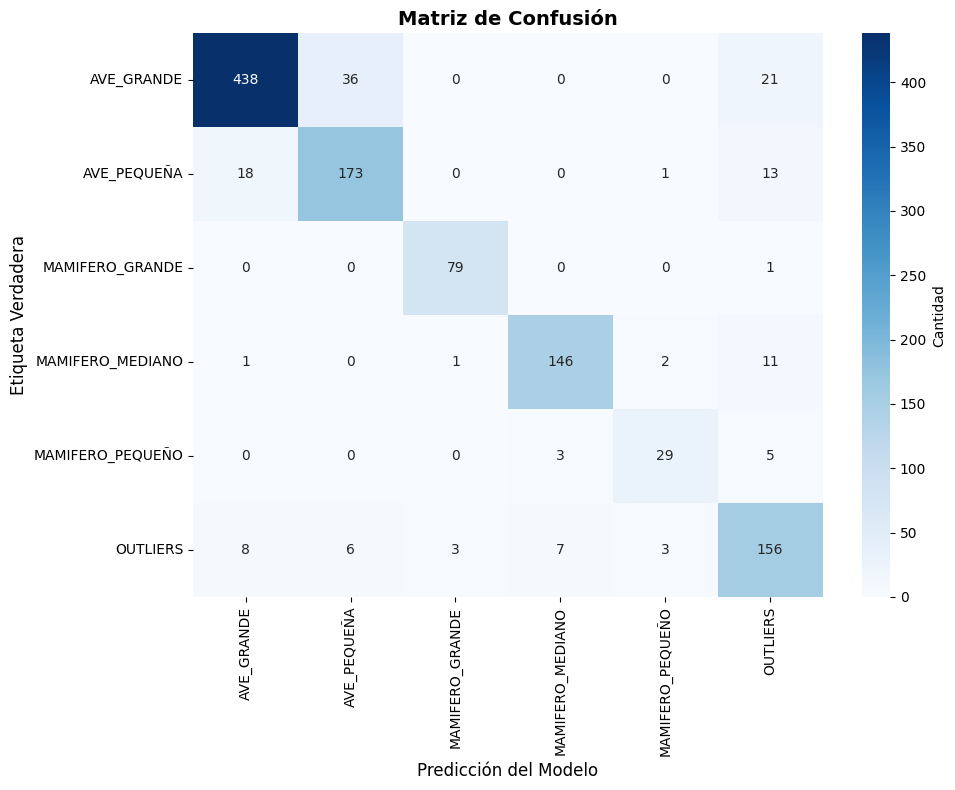


██████████████████████████████████████████████████████████████████████
📊 EVALUACIÓN EN TEST SET
██████████████████████████████████████████████████████████████████████

🎯 MÉTRICAS GLOBALES
Accuracy:  0.8649 (86.49%)
Precision: 0.8719
Recall:    0.8649
F1-Score:  0.8670

📋 REPORTE POR CLASE
                  precision    recall  f1-score   support

      AVE_GRANDE     0.9384    0.8625    0.8988       618
     AVE_PEQUEÑA     0.7590    0.8275    0.7917       255
 MAMIFERO_GRANDE     0.9896    0.9500    0.9694       100
MAMIFERO_MEDIANO     0.9154    0.9109    0.9132       202
MAMIFERO_PEQUEÑO     0.7255    0.7872    0.7551        47
        OUTLIERS     0.7588    0.8515    0.8025       229

        accuracy                         0.8649      1451
       macro avg     0.8478    0.8649    0.8551      1451
    weighted avg     0.8719    0.8649    0.8670      1451



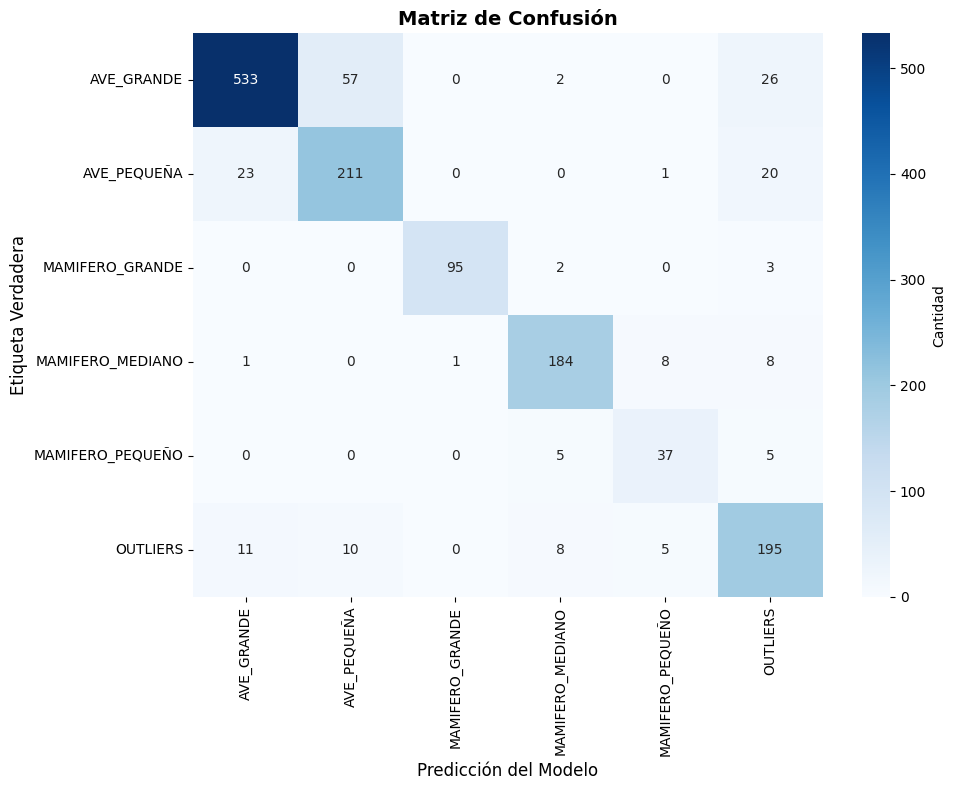


📈 MÉTRICAS DETALLADAS POR CLASE (VALIDATION)



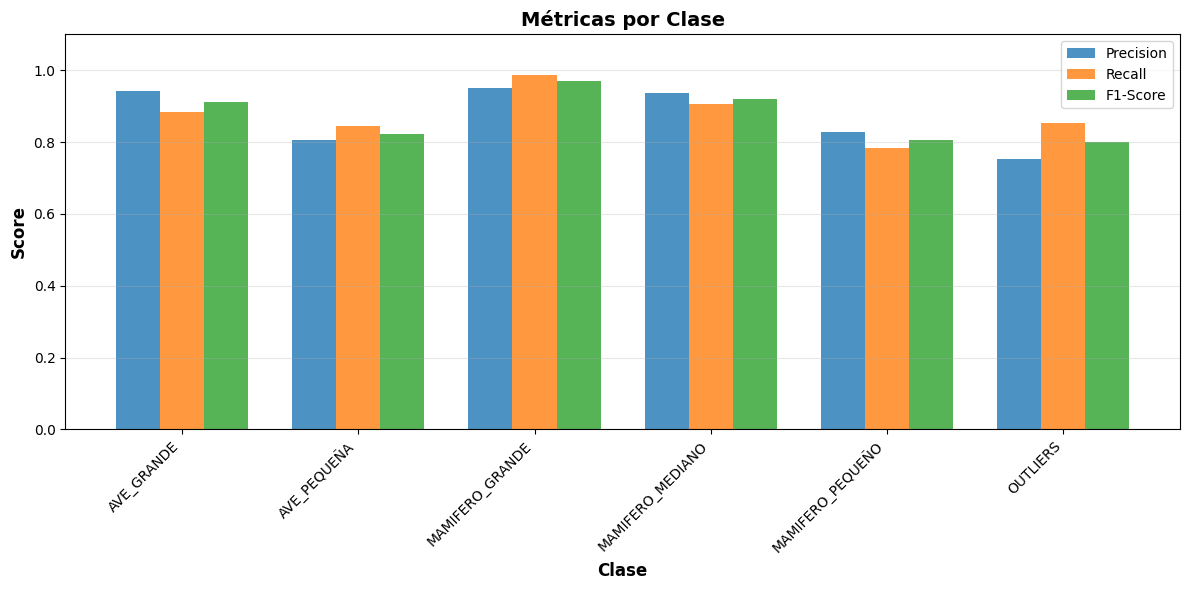


📈 MÉTRICAS DETALLADAS POR CLASE (TEST)



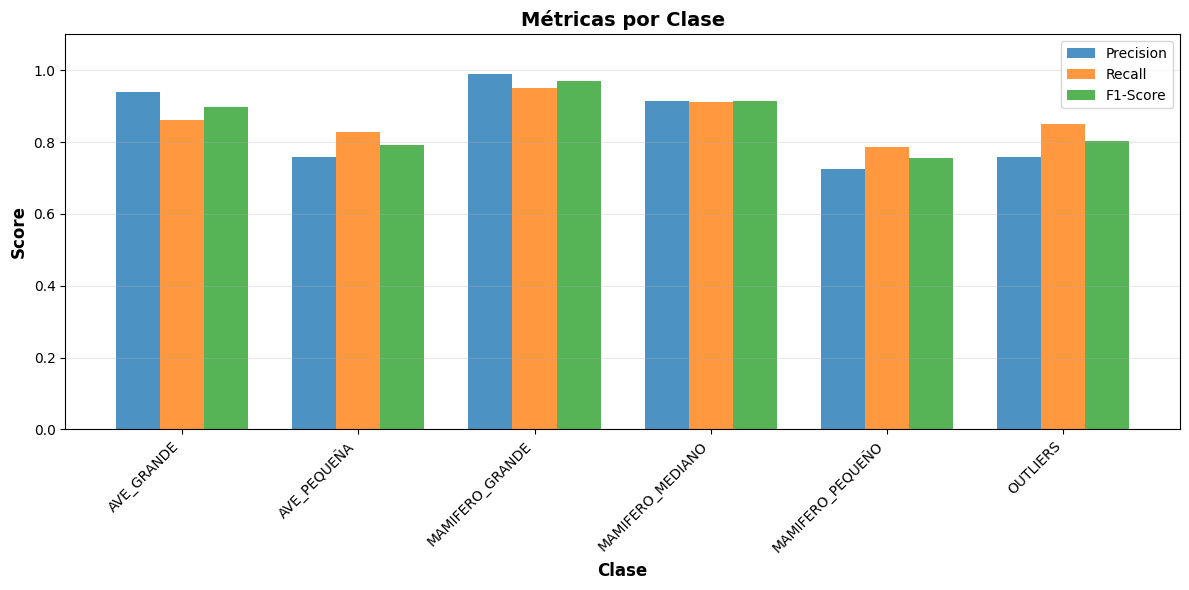


✅ Evaluación completada en ambos conjuntos


In [12]:
# ════════════════════════════════════════════════════════════════════════════
# PASO 4: EVALUAR MODELO EN VALIDATION Y TEST
# ════════════════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("🔍 PASO 4: EVALUANDO MODELO EN VALIDATION Y TEST SETS")
print("=" * 70 + "\n")

# Evaluar en validation set
print("\n" + "█" * 70)
print("📊 EVALUACIÓN EN VALIDATION SET")
print("█" * 70 + "\n")
results_val = evaluate_model(mlp, X_val, y_val, classes)

# Evaluar en test set
print("\n" + "█" * 70)
print("📊 EVALUACIÓN EN TEST SET")
print("█" * 70 + "\n")
results_test = evaluate_model(mlp, X_test, y_test, classes)

# Métricas por clase - Validation
print("\n" + "=" * 70)
print("📈 MÉTRICAS DETALLADAS POR CLASE (VALIDATION)")
print("=" * 70 + "\n")
precision_val, recall_val, f1_val = plot_per_class_metrics(
    results_val['y_test'], results_val['predictions'], classes
)

# Métricas por clase - Test
print("\n" + "=" * 70)
print("📈 MÉTRICAS DETALLADAS POR CLASE (TEST)")
print("=" * 70 + "\n")
precision_test, recall_test, f1_test = plot_per_class_metrics(
    results_test['y_test'], results_test['predictions'], classes
)

print("\n✅ Evaluación completada en ambos conjuntos")



📊 PASO 5: GRÁFICAS COMPARATIVAS VALIDATION vs TEST



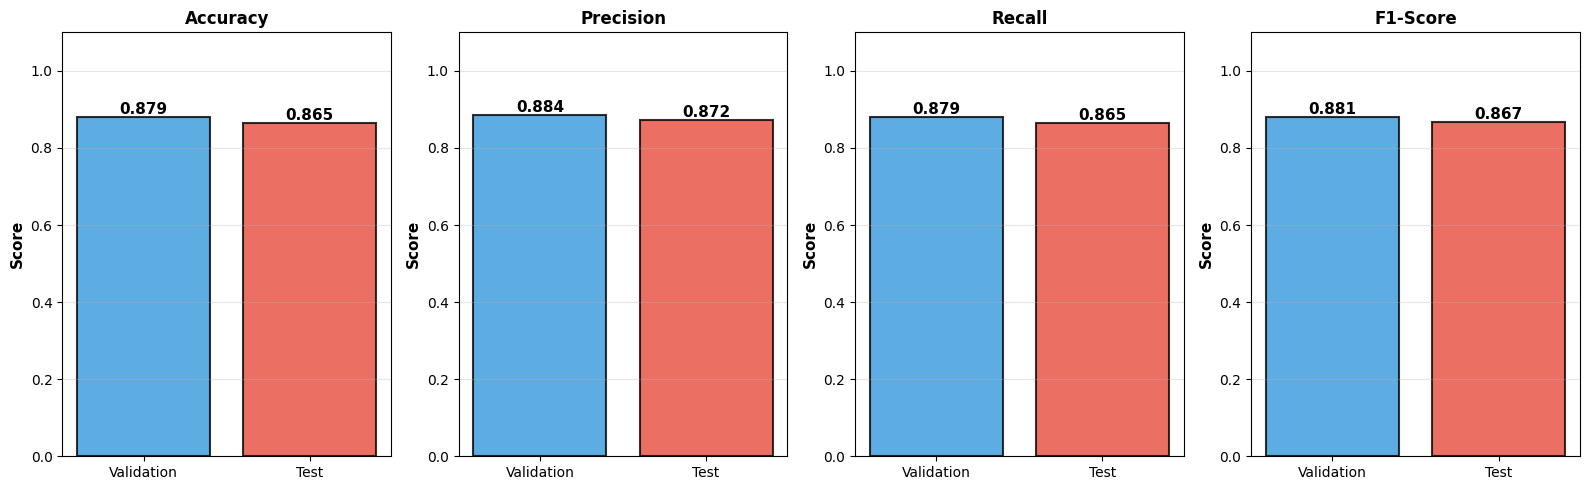

✅ Gráfica 1: Métricas globales (Validation vs Test)


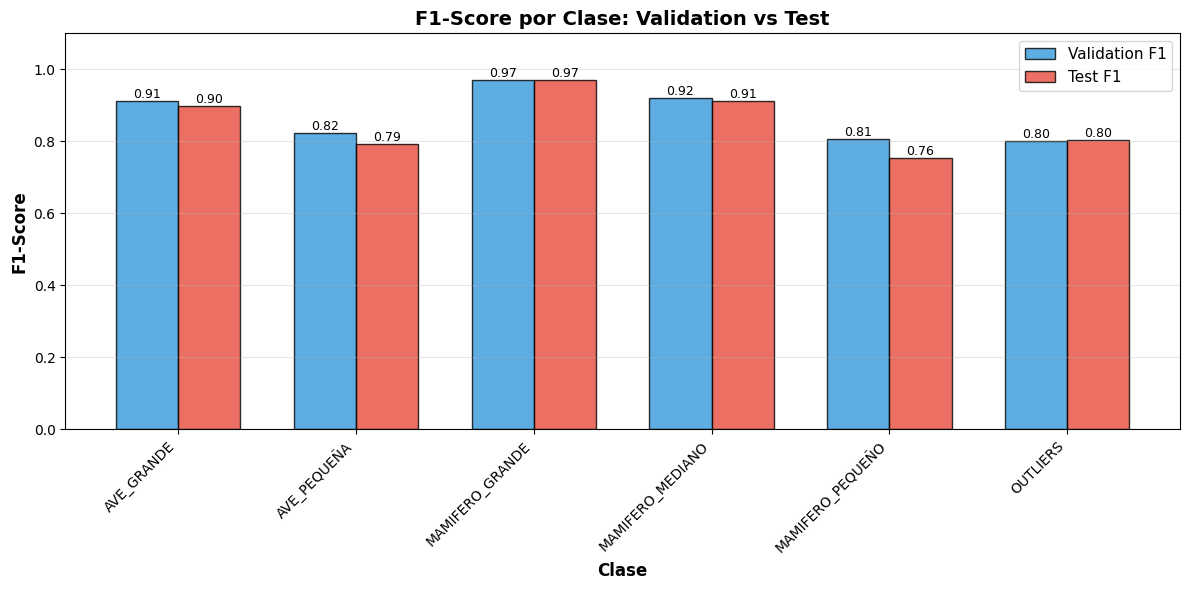

✅ Gráfica 2: F1-Score por clase (Validation vs Test)


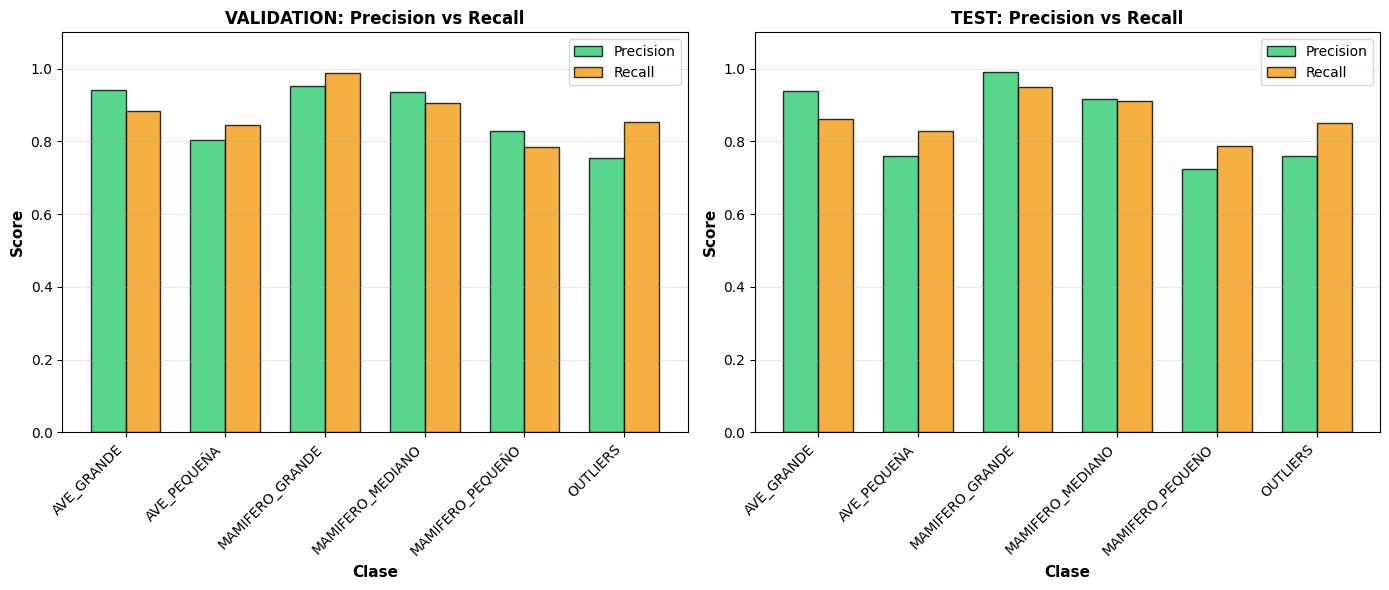

✅ Gráfica 3: Precision vs Recall (Validation y Test)

📋 RESUMEN COMPARATIVO: VALIDATION vs TEST

Métrica         Validation      Test            Diferencia     
----------------------------------------------------------------------
Accuracy        0.8794          0.8649          0.0145         
Precision       0.8842          0.8719          0.0123         
Recall          0.8794          0.8649          0.0145         
F1-Score        0.8808          0.8670          0.0138         

✨ Análisis:
✅ Diferencia mínima (0.014) → Modelo generaliza bien!

✅ Evaluación completada con éxito!


In [13]:
# ════════════════════════════════════════════════════════════════════════════
# PASO 5: COMPARACIÓN VISUAL VAL vs TEST
# ════════════════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("📊 PASO 5: GRÁFICAS COMPARATIVAS VALIDATION vs TEST")
print("=" * 70 + "\n")

# Gráfica 1: Métricas globales lado a lado
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

metrics_val = [results_val['accuracy'], results_val['precision'], results_val['recall'], results_val['f1']]
metrics_test = [results_test['accuracy'], results_test['precision'], results_test['recall'], results_test['f1']]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_val = '#3498db'
colors_test = '#e74c3c'

for idx, (name, val, test) in enumerate(zip(metric_names, metrics_val, metrics_test)):
    ax = axes[idx]
    x_pos = [0, 1]
    values = [val, test]
    bars = ax.bar(x_pos, values, color=[colors_val, colors_test], alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Agregar valores en las barras
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.3f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Validation', 'Test'], fontsize=10)
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Gráfica 1: Métricas globales (Validation vs Test)")

# ════════════════════════════════════════════════════════════════════════════
# Gráfica 2: F1-Score por clase - Comparación
# ════════════════════════════════════════════════════════════════════════════

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(classes))
width = 0.35

bars1 = ax.bar(x - width/2, f1_val, width, label='Validation F1', alpha=0.8, color='#3498db', edgecolor='black')
bars2 = ax.bar(x + width/2, f1_test, width, label='Test F1', alpha=0.8, color='#e74c3c', edgecolor='black')

# Agregar valores
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Clase', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('F1-Score por Clase: Validation vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

print("✅ Gráfica 2: F1-Score por clase (Validation vs Test)")

# ════════════════════════════════════════════════════════════════════════════
# Gráfica 3: Precision vs Recall por clase
# ════════════════════════════════════════════════════════════════════════════

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Validation
x = np.arange(len(classes))
width = 0.35

ax1.bar(x - width/2, precision_val, width, label='Precision', alpha=0.8, color='#2ecc71', edgecolor='black')
ax1.bar(x + width/2, recall_val, width, label='Recall', alpha=0.8, color='#f39c12', edgecolor='black')
ax1.set_xlabel('Clase', fontsize=11, fontweight='bold')
ax1.set_ylabel('Score', fontsize=11, fontweight='bold')
ax1.set_title('VALIDATION: Precision vs Recall', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(classes, rotation=45, ha='right')
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.1])

# Test
ax2.bar(x - width/2, precision_test, width, label='Precision', alpha=0.8, color='#2ecc71', edgecolor='black')
ax2.bar(x + width/2, recall_test, width, label='Recall', alpha=0.8, color='#f39c12', edgecolor='black')
ax2.set_xlabel('Clase', fontsize=11, fontweight='bold')
ax2.set_ylabel('Score', fontsize=11, fontweight='bold')
ax2.set_title('TEST: Precision vs Recall', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(classes, rotation=45, ha='right')
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

print("✅ Gráfica 3: Precision vs Recall (Validation y Test)")

# ════════════════════════════════════════════════════════════════════════════
# Tabla resumen
# ════════════════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("📋 RESUMEN COMPARATIVO: VALIDATION vs TEST")
print("=" * 70)
print(f"\n{'Métrica':<15} {'Validation':<15} {'Test':<15} {'Diferencia':<15}")
print("-" * 70)
print(f"{'Accuracy':<15} {results_val['accuracy']:<15.4f} {results_test['accuracy']:<15.4f} {results_val['accuracy']-results_test['accuracy']:<15.4f}")
print(f"{'Precision':<15} {results_val['precision']:<15.4f} {results_test['precision']:<15.4f} {results_val['precision']-results_test['precision']:<15.4f}")
print(f"{'Recall':<15} {results_val['recall']:<15.4f} {results_test['recall']:<15.4f} {results_val['recall']-results_test['recall']:<15.4f}")
print(f"{'F1-Score':<15} {results_val['f1']:<15.4f} {results_test['f1']:<15.4f} {results_val['f1']-results_test['f1']:<15.4f}")
print("=" * 70)

print("\n✨ Análisis:")
diff_f1 = results_val['f1'] - results_test['f1']
if diff_f1 > 0.1:
    print(f"⚠️  Hay diferencia notable ({diff_f1:.3f}) → Posible sobreajuste")
elif diff_f1 > 0.05:
    print(f"⚠️  Hay ligera diferencia ({diff_f1:.3f}) → Comportamiento normal")
else:
    print(f"✅ Diferencia mínima ({diff_f1:.3f}) → Modelo generaliza bien!")

print("\n✅ Evaluación completada con éxito!")
